In [1]:
from src.layers import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [2]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'de'
lang2 = 'en'

train_sentences, test_sentences = load_data(lang1, lang2)
train_sentences = (train_sentences[0][:500], train_sentences[1][:500])

In [3]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, test_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [4]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 500
Number of validation examples: 1014
Training Batches 8	Validation Batches 8


In [5]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (de) vocabulary: 1348
Unique tokens in target (en) vocabulary: 1224


# Make the Model

In [6]:
NUM_LAYERS=1
MODEL_DIM=128
NUM_HEADS=8
DFF=128

# SEQ2SEQ ARGS
MAX_LENGTH = max(train_loader.dataset.tensors[1].size(1), train_loader.dataset.tensors[0].size(1)) + 3
SOS_TOKEN = tgt_vocab.SOS_token
TEACHER_FORCING = 1.0

In [7]:
seq2seq = Transformer(NUM_LAYERS, MODEL_DIM, NUM_HEADS, DFF)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 4,115,472 trainable parameters


In [8]:
print(seq2seq)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(10000, 128)
    (pos_encoding): PositionalEmbeddings(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiheadAttention(
          (wq): Linear(in_features=128, out_features=128, bias=True)
          (wk): Linear(in_features=128, out_features=128, bias=True)
          (wv): Linear(in_features=128, out_features=128, bias=True)
          (dense): Linear(in_features=128, out_features=128, bias=True)
        )
        (ffn): PointwiseFeedForward(
          (dense_1): Linear(in_features=128, out_features=128, bias=True)
          (dense_2): Linear(in_features=128, out_features=128, bias=True)
        )
        (layernorm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
     

In [9]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [10]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)

In [11]:
# valid_loss

In [64]:
N_EPOCHS = 50
CLIP = 1

# seq2seq.teacher_forcing = 1.0

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
    valid_loss = evaluate(seq2seq, train_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_conv.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01
100%|██████████| 8/8 [00:01<00:00,  4.31it/s]
	Train Loss: 0.272 | Train PPL:   1.312
	 Val. Loss: 0.168 |  Val. PPL:   1.182
Epoch: 02
100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
	Train Loss: 0.261 | Train PPL:   1.298
	 Val. Loss: 0.162 |  Val. PPL:   1.176
Epoch: 03
100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
	Train Loss: 0.259 | Train PPL:   1.296
	 Val. Loss: 0.163 |  Val. PPL:   1.177
Epoch: 04
100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
	Train Loss: 0.263 | Train PPL:   1.300
	 Val. Loss: 0.163 |  Val. PPL:   1.177
Epoch: 05
100%|██████████| 8/8 [00:01<00:00,  4.30it/s]
	Train Loss: 0.262 | Train PPL:   1.300
	 Val. Loss: 0.163 |  Val. PPL:   1.177
Epoch: 06
100%|██████████| 8/8 [00:02<00:00,  3.32it/s]
	Train Loss: 0.253 | Train PPL:   1.288
	 Val. Loss: 0.161 |  Val. PPL:   1.175
Epoch: 07
100%|██████████| 8/8 [00:03<00:00,  2.31it/s]
	Train Loss: 0.252 | Train PPL:   1.287
	 Val. Loss: 0.162 |  Val. PPL:   1.176
Epoch: 08
100%|██████████| 8/8 [00:02<00:00,  4.

100%|██████████| 8/8 [00:02<00:00,  3.29it/s]
	Train Loss: 0.218 | Train PPL:   1.244
	 Val. Loss: 0.147 |  Val. PPL:   1.159
Epoch: 47
100%|██████████| 8/8 [00:02<00:00,  3.92it/s]
	Train Loss: 0.213 | Train PPL:   1.237
	 Val. Loss: 0.155 |  Val. PPL:   1.167
Epoch: 48
100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
	Train Loss: 0.218 | Train PPL:   1.244
	 Val. Loss: 0.152 |  Val. PPL:   1.164
Epoch: 49
100%|██████████| 8/8 [00:02<00:00,  3.92it/s]
	Train Loss: 0.215 | Train PPL:   1.240
	 Val. Loss: 0.153 |  Val. PPL:   1.165
Epoch: 50
100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
	Train Loss: 0.211 | Train PPL:   1.235
	 Val. Loss: 0.153 |  Val. PPL:   1.165


In [97]:
idx = 286
src_sentence = train_loader.dataset.tensors[0][idx:idx+1][:, :20]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1][:, :20]
print(src_sentence[:, :19])
print(tgt_sentence[:, :21])
print(src_sentence.size(), tgt_sentence.size())
print(src_vocab.to_string(src_sentence))
print(tgt_vocab.to_string(tgt_sentence))
m1, m2, m3 = create_masks(src_sentence, tgt_sentence, 0)
out, attention = seq2seq(src_sentence, tgt_sentence, m1, m2, m3)

tensor([[  2,  16, 145, 139,   9, 131, 988,   3,   4,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0]])
tensor([[  3,   7, 124, 112,   2,  27, 921, 922,   5,   4,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]])
torch.Size([1, 20]) torch.Size([1, 20])
['<sos> die dame hat eine schwarze umhangetasche . <eos>']
['<sos> the lady has a black sling bag . <eos>']


In [98]:
out.size(), attention.keys()

(torch.Size([1, 20, 10000]),
 dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2']))

In [99]:
translation = tgt_vocab.to_string(out.argmax(dim=-1))[0]
translation

'the lady has a black sling bag . <eos> a full full full full full full full full full full'

In [100]:
attention['decoder_layer1_block1'].squeeze(0).mean(dim=0).shape

torch.Size([20, 20])

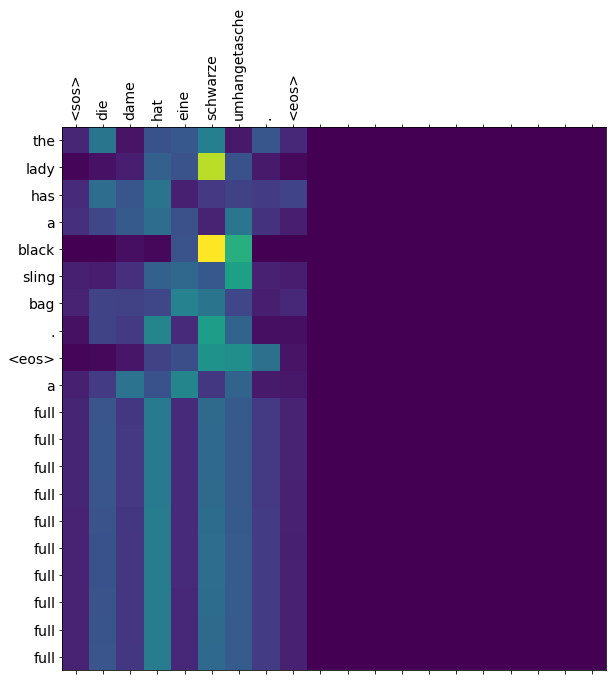

In [104]:
plot_attention(attention['decoder_layer1_block2'].squeeze(0).mean(0), src_vocab.to_string(src_sentence)[0], translation)

In [113]:
def evaluate_translate(model, iterator, criterion, pad_tok=0):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(tqdm(iterator, file=sys.stdout)):
            # src.shape = (batch_size, src_seq_len)
            # tgt.shape = (batch_size, tgt_seq_len)
            src_mask = create_padding_mask(src, pad_tok)

            if model.type == 'rnn':
                output, attention = model(src, None, src_mask) #turn off teacher forcing
                # output.shape == (batch_size, max_length, tgt_vocab_size)
                # print(output)
                # output = output[:, 1:, :]
                tgt = tgt[:, 1:]
            elif model.type == 'conv':
                output, attention = model(src, None) #turn off teacher forcing
                tgt = tgt[:, 1:]

            loss = criterion(output, tgt) # masked loss automatically slices for you

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [114]:
valid_loss = evaluate_translate(seq2seq, train_loader, criterion)






  0%|          | 0/8 [00:00<?, ?it/s]




 12%|█▎        | 1/8 [00:03<00:21,  3.12s/it]




 25%|██▌       | 2/8 [00:06<00:19,  3.23s/it]




 38%|███▊      | 3/8 [00:09<00:16,  3.23s/it]




 50%|█████     | 4/8 [00:13<00:12,  3.23s/it]




 62%|██████▎   | 5/8 [00:16<00:09,  3.20s/it]




 75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]




 88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]




100%|██████████| 8/8 [00:25<00:00,  2.98s/it]

In [119]:
valid_loss, math.exp(valid_loss)

(0.8958491086959839, 2.4494147260598007)

In [153]:
idx = 0

src_sentence = train_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1]

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

In [154]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[  2,  19,  21,  29,  32,  35, 146,  17,  57,   8,  15,  58, 478, 479,
           3,   4]])
tensor([[35, 22,  5,  4,  5,  4,  5,  5,  4,  5,  5,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4]])


In [155]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> zwei junge wei e manner sind im freien in der nahe vieler busche .
= two young , white males are outside near many bushes .
< men boy . . . . . .


In [156]:
src_vocab.PAD_token

0

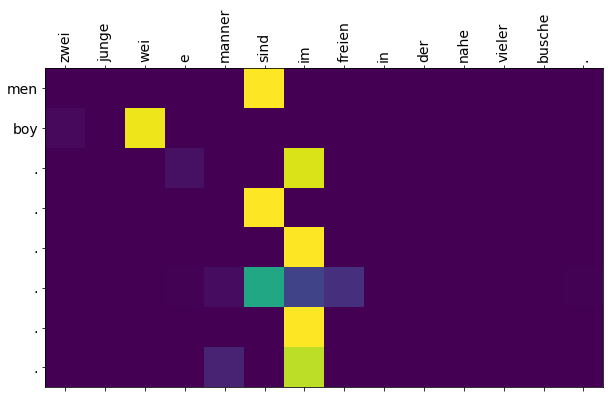

In [157]:
plot_attention(attention, src_sentence, translation)

In [55]:
attention

tensor([[4.3664e-11, 1.0312e-04, 1.2130e-21, 3.2909e-11, 1.0098e-01, 4.4736e-09,
         1.2194e-10, 8.9715e-10, 2.9493e-08, 2.2802e-06, 3.1995e-07, 1.0730e-09,
         5.1280e-10, 8.9890e-01, 1.6924e-05],
        [1.2821e-07, 2.2048e-11, 2.5935e-09, 8.2775e-04, 9.6637e-01, 1.8144e-03,
         3.6247e-08, 2.3610e-04, 2.4396e-05, 4.4837e-04, 2.9789e-02, 6.7302e-11,
         3.1570e-04, 1.6431e-04, 1.5167e-10],
        [9.7672e-09, 6.2471e-34, 8.9530e-07, 1.5813e-14, 3.4575e-20, 6.9667e-19,
         5.8963e-15, 1.4152e-18, 6.0852e-06, 5.0482e-12, 5.8400e-28, 2.9403e-39,
         4.2869e-13, 4.5173e-11, 9.9999e-01],
        [3.0974e-24, 6.0256e-44, 0.0000e+00, 3.3918e-30, 1.8024e-25, 8.6161e-30,
         1.4547e-22, 8.9977e-25, 8.0511e-24, 3.4063e-20, 2.0275e-40, 0.0000e+00,
         2.0891e-32, 7.1727e-18, 1.0000e+00],
        [8.9777e-29, 0.0000e+00, 0.0000e+00, 1.0618e-32, 7.0668e-37, 3.0974e-39,
         2.0014e-30, 1.1380e-33, 3.5251e-30, 6.0993e-26, 0.0000e+00, 0.0000e+00,
      

In [ ]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)